In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose,MaxPool2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
import random
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

#PATH of the project folder
PROJECT_ROOT_DIR=os.getcwd()

#Create Images folder
IMAGES_PATH=os.path.join(PROJECT_ROOT_DIR,"Images")
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

#Function to save figures in the images folder
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(IMAGES_PATH, fig_id + ".png")
    print("Figure {} saved".format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
#THRESHOLD for Other function
THRESHOLD=300




In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [90]:
X_train.shape

(60000, 28, 28)

In [0]:
#input dimensions
input_rows = 28
input_cols = 28
input_channels = 1
latent_dim=100

In [0]:
def image_random(nbr_img):
    name_image=[]
    nbr_index=[]
    for i in range(nbr_img):
        unique=True
        while unique:
            index = random.randrange(0, X_train.shape[0])
            if index not in nbr_index:
                nbr_index.append(index)
                unique=False
        name_image.append(X_train[index])
    return name_image

In [0]:
def visualization_image(images,sizeh,sizev):
    length=len(images)
    plt.figure(figsize=(sizeh,sizev))
    cpt=0
    for each in images:
        cpt+=1
        plt.subplot(1,length,cpt)
        plt.imshow(each,cmap='Greys')
    plt.tight_layout()
    save_fig('Random_Images')
    plt.show()

Figure Random_Images saved


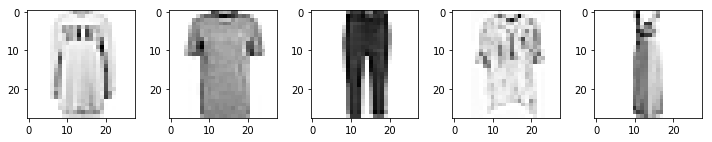

In [94]:
visualization_image(random_image,10,10)

In [0]:
X_train = X_train/127.5-1

In [96]:
X_train=X_train.reshape(X_train.shape+(1,))
X_train.shape

(60000, 28, 28, 1)

In [0]:
def generator_model(latent_dim):
  model = Sequential()

  model.add(Dense(256, input_dim=latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))

  model.summary()

  noise = Input(shape=(latent_dim,))

  img = model(noise)

  return Model(noise, img)

In [0]:
def discriminator_model(input_rows,input_cols,input_channels):
  model = Sequential()

  model.add(Flatten(input_shape=(input_rows,input_cols,input_channels))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(input_rows,input_cols,input_channels))
  validity = model(img)

  return Model(img, validity)

In [99]:
generator = generator_model(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dense_32 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 512)               2048      
_________________________________________________________________
dense_33 (Dense)             (None, 1024)             

In [100]:
#input dimensions
discriminator = create_discriminator(input_rows,input_cols,input_channels)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

In [0]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

In [0]:
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

0 [D loss: 0.700434, acc.: 51.56%] [G loss: 0.872722]


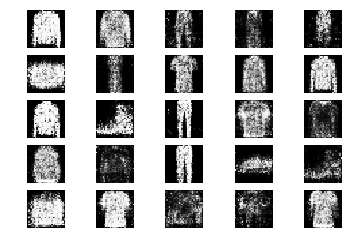

200 [D loss: 0.670389, acc.: 56.25%] [G loss: 0.892310]
400 [D loss: 0.689415, acc.: 60.94%] [G loss: 0.870790]
600 [D loss: 0.714119, acc.: 50.00%] [G loss: 0.926246]
800 [D loss: 0.649215, acc.: 57.81%] [G loss: 0.923779]
1000 [D loss: 0.652811, acc.: 68.75%] [G loss: 0.865045]


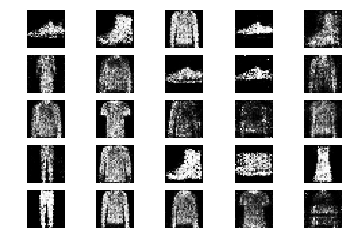

1200 [D loss: 0.688426, acc.: 54.69%] [G loss: 0.859986]
1400 [D loss: 0.631822, acc.: 70.31%] [G loss: 0.938532]
1600 [D loss: 0.637941, acc.: 60.94%] [G loss: 0.944751]
1800 [D loss: 0.666474, acc.: 62.50%] [G loss: 1.001403]
2000 [D loss: 0.616086, acc.: 64.06%] [G loss: 0.875635]


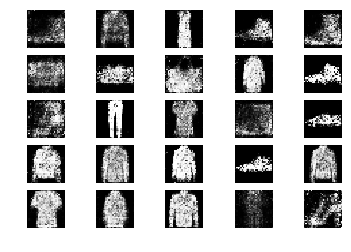

2200 [D loss: 0.679674, acc.: 53.12%] [G loss: 0.967402]
2400 [D loss: 0.618733, acc.: 65.62%] [G loss: 0.864855]
2600 [D loss: 0.661210, acc.: 54.69%] [G loss: 0.902832]
2800 [D loss: 0.635360, acc.: 73.44%] [G loss: 0.971076]
3000 [D loss: 0.615093, acc.: 68.75%] [G loss: 0.913349]


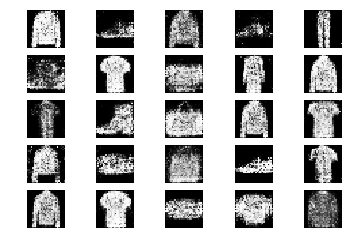

3200 [D loss: 0.676746, acc.: 56.25%] [G loss: 0.842897]
3400 [D loss: 0.640922, acc.: 62.50%] [G loss: 0.952734]
3600 [D loss: 0.690099, acc.: 59.38%] [G loss: 0.945550]
3800 [D loss: 0.659157, acc.: 56.25%] [G loss: 0.961767]
4000 [D loss: 0.647026, acc.: 59.38%] [G loss: 1.123678]


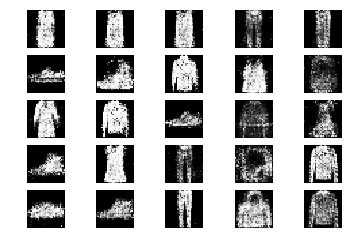

4200 [D loss: 0.622605, acc.: 71.88%] [G loss: 0.856966]
4400 [D loss: 0.626995, acc.: 64.06%] [G loss: 1.005621]
4600 [D loss: 0.686782, acc.: 60.94%] [G loss: 0.942609]
4800 [D loss: 0.689721, acc.: 57.81%] [G loss: 0.948784]
5000 [D loss: 0.619889, acc.: 68.75%] [G loss: 0.910755]


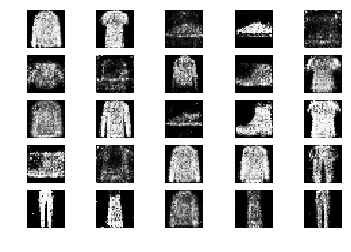

5200 [D loss: 0.684897, acc.: 60.94%] [G loss: 0.945217]
5400 [D loss: 0.598539, acc.: 70.31%] [G loss: 0.902870]
5600 [D loss: 0.596645, acc.: 70.31%] [G loss: 0.950725]
5800 [D loss: 0.618172, acc.: 62.50%] [G loss: 0.850316]
6000 [D loss: 0.623488, acc.: 60.94%] [G loss: 0.867334]


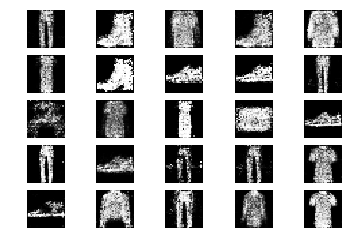

6200 [D loss: 0.636598, acc.: 60.94%] [G loss: 0.915298]
6400 [D loss: 0.624666, acc.: 75.00%] [G loss: 0.856394]
6600 [D loss: 0.636790, acc.: 64.06%] [G loss: 0.912972]
6800 [D loss: 0.666559, acc.: 53.12%] [G loss: 0.976962]
7000 [D loss: 0.705667, acc.: 50.00%] [G loss: 0.911184]


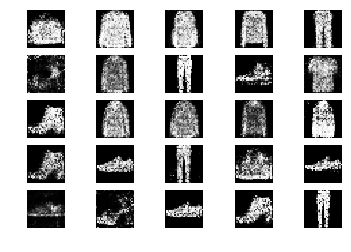

7200 [D loss: 0.585123, acc.: 64.06%] [G loss: 0.919453]
7400 [D loss: 0.636752, acc.: 65.62%] [G loss: 1.067986]
7600 [D loss: 0.641325, acc.: 65.62%] [G loss: 0.941798]
7800 [D loss: 0.686451, acc.: 50.00%] [G loss: 1.019873]
8000 [D loss: 0.601075, acc.: 64.06%] [G loss: 0.915910]


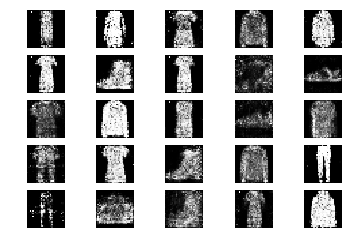

8200 [D loss: 0.710537, acc.: 56.25%] [G loss: 0.959276]
8400 [D loss: 0.635077, acc.: 70.31%] [G loss: 1.019078]
8600 [D loss: 0.586902, acc.: 62.50%] [G loss: 0.965355]
8800 [D loss: 0.637256, acc.: 57.81%] [G loss: 0.935487]
9000 [D loss: 0.704441, acc.: 57.81%] [G loss: 0.955137]


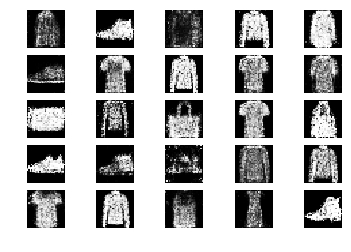

9200 [D loss: 0.604943, acc.: 70.31%] [G loss: 1.018006]
9400 [D loss: 0.684688, acc.: 54.69%] [G loss: 0.840222]
9600 [D loss: 0.656479, acc.: 56.25%] [G loss: 0.994941]
9800 [D loss: 0.667099, acc.: 64.06%] [G loss: 0.946973]
10000 [D loss: 0.642888, acc.: 64.06%] [G loss: 0.930890]


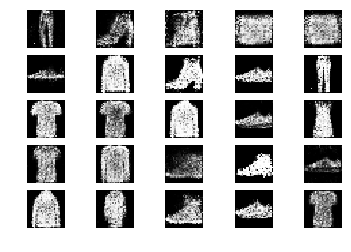

10200 [D loss: 0.659250, acc.: 51.56%] [G loss: 0.939153]
10400 [D loss: 0.605985, acc.: 68.75%] [G loss: 0.968645]
10600 [D loss: 0.623661, acc.: 60.94%] [G loss: 0.964659]
10800 [D loss: 0.660348, acc.: 64.06%] [G loss: 1.011956]
11000 [D loss: 0.663448, acc.: 50.00%] [G loss: 0.963888]


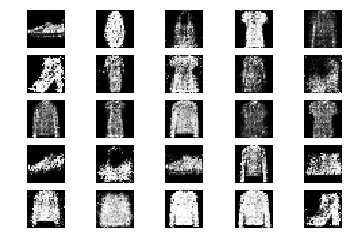

11200 [D loss: 0.624539, acc.: 67.19%] [G loss: 0.993272]
11400 [D loss: 0.723115, acc.: 56.25%] [G loss: 0.925162]
11600 [D loss: 0.704558, acc.: 48.44%] [G loss: 0.879675]
11800 [D loss: 0.653494, acc.: 64.06%] [G loss: 0.916074]
12000 [D loss: 0.644098, acc.: 65.62%] [G loss: 0.916921]


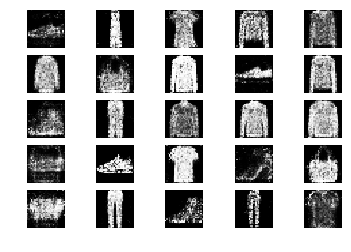

12200 [D loss: 0.639902, acc.: 54.69%] [G loss: 0.904044]
12400 [D loss: 0.680926, acc.: 57.81%] [G loss: 0.956822]
12600 [D loss: 0.584428, acc.: 81.25%] [G loss: 0.915208]
12800 [D loss: 0.611113, acc.: 64.06%] [G loss: 1.013407]
13000 [D loss: 0.661503, acc.: 59.38%] [G loss: 0.964277]


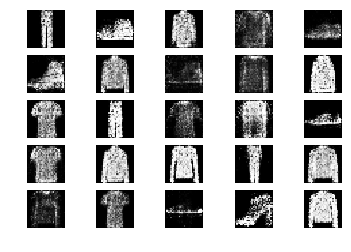

13200 [D loss: 0.726930, acc.: 62.50%] [G loss: 0.936828]
13400 [D loss: 0.621847, acc.: 62.50%] [G loss: 0.924137]
13600 [D loss: 0.640208, acc.: 60.94%] [G loss: 0.937304]
13800 [D loss: 0.678013, acc.: 56.25%] [G loss: 0.921944]
14000 [D loss: 0.693720, acc.: 59.38%] [G loss: 0.976415]


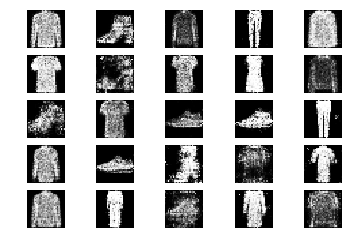

14200 [D loss: 0.599628, acc.: 70.31%] [G loss: 0.949845]
14400 [D loss: 0.574744, acc.: 71.88%] [G loss: 0.824181]
14600 [D loss: 0.758278, acc.: 46.88%] [G loss: 0.804968]
14800 [D loss: 0.673710, acc.: 59.38%] [G loss: 1.061423]
15000 [D loss: 0.561492, acc.: 70.31%] [G loss: 0.910017]


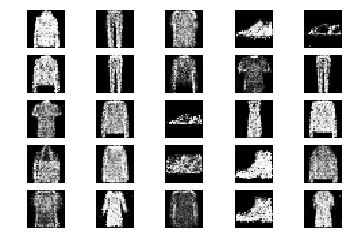

15200 [D loss: 0.601426, acc.: 67.19%] [G loss: 0.954389]
15400 [D loss: 0.563285, acc.: 75.00%] [G loss: 0.841195]
15600 [D loss: 0.603674, acc.: 64.06%] [G loss: 0.942015]
15800 [D loss: 0.608130, acc.: 65.62%] [G loss: 0.926382]
16000 [D loss: 0.621377, acc.: 62.50%] [G loss: 0.990808]


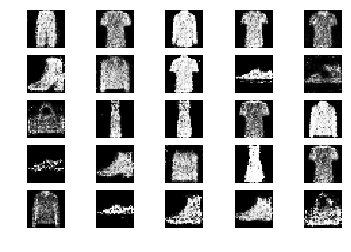

16200 [D loss: 0.657162, acc.: 62.50%] [G loss: 0.990582]
16400 [D loss: 0.676535, acc.: 59.38%] [G loss: 0.935631]
16600 [D loss: 0.607730, acc.: 65.62%] [G loss: 1.100186]
16800 [D loss: 0.698822, acc.: 50.00%] [G loss: 0.977274]
17000 [D loss: 0.699818, acc.: 53.12%] [G loss: 0.971853]


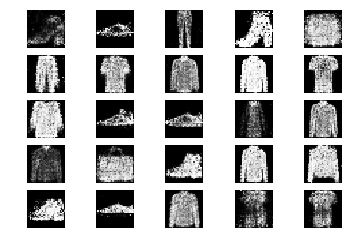

17200 [D loss: 0.664294, acc.: 56.25%] [G loss: 0.916408]
17400 [D loss: 0.647748, acc.: 60.94%] [G loss: 0.981700]
17600 [D loss: 0.689177, acc.: 64.06%] [G loss: 0.979671]
17800 [D loss: 0.615562, acc.: 64.06%] [G loss: 0.997731]
18000 [D loss: 0.663184, acc.: 56.25%] [G loss: 0.886897]


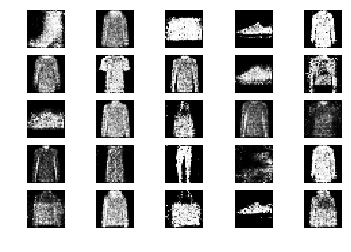

18200 [D loss: 0.591333, acc.: 70.31%] [G loss: 0.909310]
18400 [D loss: 0.610819, acc.: 65.62%] [G loss: 1.025248]
18600 [D loss: 0.647973, acc.: 60.94%] [G loss: 0.931209]
18800 [D loss: 0.579563, acc.: 70.31%] [G loss: 0.931427]
19000 [D loss: 0.656253, acc.: 64.06%] [G loss: 0.906247]


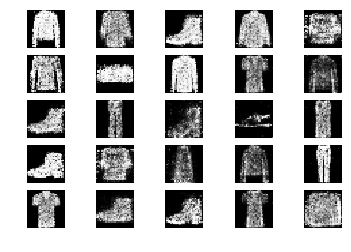

19200 [D loss: 0.672443, acc.: 50.00%] [G loss: 1.038783]
19400 [D loss: 0.663731, acc.: 59.38%] [G loss: 0.913641]
19600 [D loss: 0.633000, acc.: 60.94%] [G loss: 1.027928]
19800 [D loss: 0.653728, acc.: 60.94%] [G loss: 1.052455]
20000 [D loss: 0.647475, acc.: 65.62%] [G loss: 0.929720]


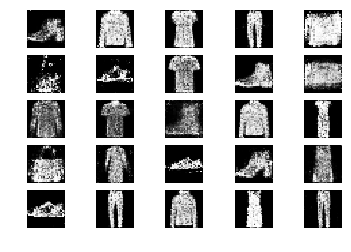

20200 [D loss: 0.653809, acc.: 57.81%] [G loss: 0.965727]
20400 [D loss: 0.644472, acc.: 71.88%] [G loss: 1.013125]
20600 [D loss: 0.683169, acc.: 56.25%] [G loss: 0.952363]
20800 [D loss: 0.559992, acc.: 73.44%] [G loss: 1.075898]
21000 [D loss: 0.643575, acc.: 60.94%] [G loss: 1.008870]


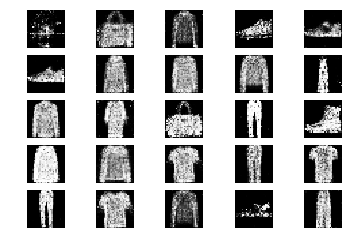

21200 [D loss: 0.668020, acc.: 59.38%] [G loss: 1.032012]
21400 [D loss: 0.669222, acc.: 60.94%] [G loss: 0.950064]
21600 [D loss: 0.649431, acc.: 56.25%] [G loss: 0.922902]
21800 [D loss: 0.616054, acc.: 67.19%] [G loss: 0.977254]
22000 [D loss: 0.614960, acc.: 70.31%] [G loss: 1.039924]


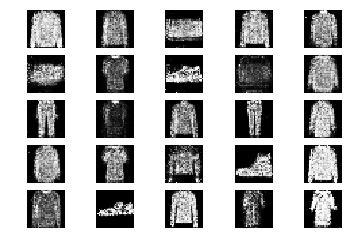

22200 [D loss: 0.672257, acc.: 62.50%] [G loss: 1.019509]
22400 [D loss: 0.646592, acc.: 65.62%] [G loss: 1.105880]
22600 [D loss: 0.587124, acc.: 76.56%] [G loss: 1.151579]
22800 [D loss: 0.658875, acc.: 59.38%] [G loss: 0.937217]
23000 [D loss: 0.632671, acc.: 60.94%] [G loss: 1.016282]


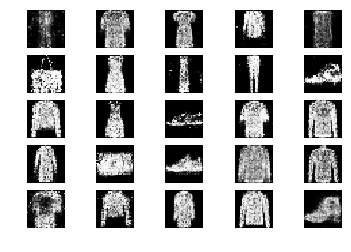

23200 [D loss: 0.588133, acc.: 65.62%] [G loss: 0.826945]
23400 [D loss: 0.667780, acc.: 64.06%] [G loss: 0.964599]
23600 [D loss: 0.677780, acc.: 50.00%] [G loss: 1.015848]
23800 [D loss: 0.626884, acc.: 56.25%] [G loss: 1.128127]
24000 [D loss: 0.560627, acc.: 70.31%] [G loss: 0.979597]


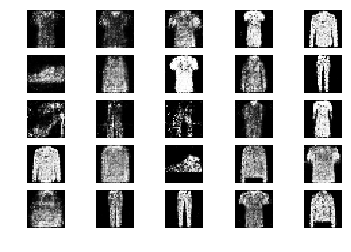

24200 [D loss: 0.650486, acc.: 60.94%] [G loss: 1.036427]
24400 [D loss: 0.611418, acc.: 60.94%] [G loss: 0.957362]
24600 [D loss: 0.711388, acc.: 53.12%] [G loss: 0.952668]
24800 [D loss: 0.605105, acc.: 64.06%] [G loss: 0.933281]
25000 [D loss: 0.643951, acc.: 64.06%] [G loss: 0.981302]


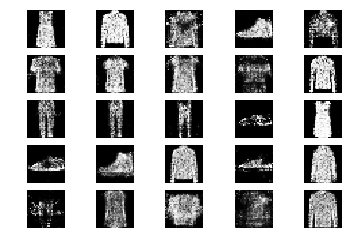

25200 [D loss: 0.640686, acc.: 62.50%] [G loss: 1.055723]
25400 [D loss: 0.662207, acc.: 54.69%] [G loss: 1.019294]
25600 [D loss: 0.593962, acc.: 71.88%] [G loss: 1.011004]
25800 [D loss: 0.613263, acc.: 67.19%] [G loss: 0.980893]
26000 [D loss: 0.549382, acc.: 76.56%] [G loss: 0.980288]


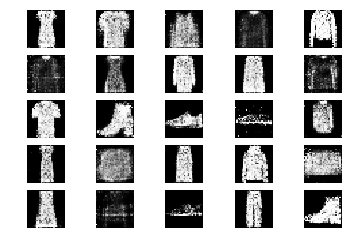

26200 [D loss: 0.583781, acc.: 75.00%] [G loss: 0.965584]
26400 [D loss: 0.615365, acc.: 62.50%] [G loss: 1.023357]
26600 [D loss: 0.677818, acc.: 51.56%] [G loss: 1.065248]
26800 [D loss: 0.714473, acc.: 50.00%] [G loss: 1.022094]
27000 [D loss: 0.655916, acc.: 62.50%] [G loss: 1.027800]


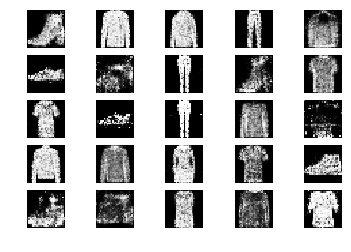

27200 [D loss: 0.657558, acc.: 65.62%] [G loss: 0.991517]
27400 [D loss: 0.614552, acc.: 64.06%] [G loss: 1.072384]
27600 [D loss: 0.603605, acc.: 65.62%] [G loss: 1.007896]
27800 [D loss: 0.616858, acc.: 67.19%] [G loss: 0.942848]
28000 [D loss: 0.642730, acc.: 59.38%] [G loss: 1.132329]


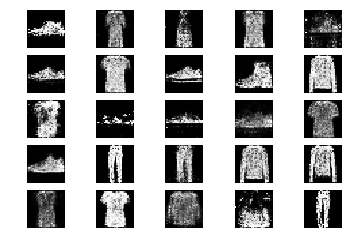

28200 [D loss: 0.669838, acc.: 54.69%] [G loss: 1.021220]
28400 [D loss: 0.650518, acc.: 59.38%] [G loss: 1.000911]
28600 [D loss: 0.547953, acc.: 73.44%] [G loss: 1.066076]
28800 [D loss: 0.658771, acc.: 57.81%] [G loss: 1.067054]
29000 [D loss: 0.580268, acc.: 70.31%] [G loss: 0.920062]


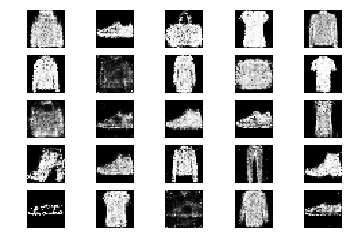

29200 [D loss: 0.620731, acc.: 65.62%] [G loss: 0.963737]
29400 [D loss: 0.608107, acc.: 67.19%] [G loss: 1.004755]
29600 [D loss: 0.691582, acc.: 59.38%] [G loss: 1.183981]
29800 [D loss: 0.691148, acc.: 56.25%] [G loss: 1.027357]
30000 [D loss: 0.657544, acc.: 57.81%] [G loss: 1.007563]


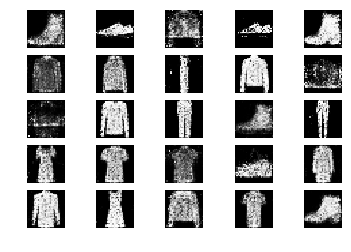

30200 [D loss: 0.611924, acc.: 62.50%] [G loss: 0.891157]
30400 [D loss: 0.630106, acc.: 59.38%] [G loss: 1.132679]
30600 [D loss: 0.644500, acc.: 62.50%] [G loss: 0.939018]
30800 [D loss: 0.606847, acc.: 67.19%] [G loss: 0.920998]
31000 [D loss: 0.589241, acc.: 67.19%] [G loss: 1.018159]


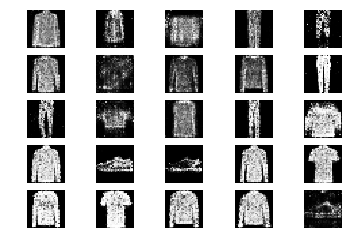

31200 [D loss: 0.657182, acc.: 60.94%] [G loss: 0.990490]
31400 [D loss: 0.674642, acc.: 59.38%] [G loss: 0.905637]
31600 [D loss: 0.629990, acc.: 57.81%] [G loss: 1.051880]
31800 [D loss: 0.553173, acc.: 73.44%] [G loss: 1.076862]
32000 [D loss: 0.646824, acc.: 62.50%] [G loss: 0.933408]


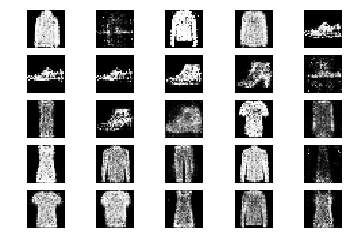

32200 [D loss: 0.647982, acc.: 67.19%] [G loss: 0.962703]
32400 [D loss: 0.642135, acc.: 67.19%] [G loss: 1.084195]
32600 [D loss: 0.711813, acc.: 54.69%] [G loss: 0.961669]
32800 [D loss: 0.720627, acc.: 56.25%] [G loss: 1.043356]
33000 [D loss: 0.557874, acc.: 75.00%] [G loss: 1.054266]


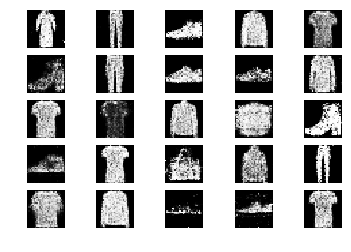

33200 [D loss: 0.602710, acc.: 62.50%] [G loss: 1.032501]
33400 [D loss: 0.567652, acc.: 68.75%] [G loss: 1.086778]
33600 [D loss: 0.631775, acc.: 67.19%] [G loss: 1.083816]
33800 [D loss: 0.635545, acc.: 64.06%] [G loss: 0.996893]
34000 [D loss: 0.652178, acc.: 62.50%] [G loss: 0.912863]


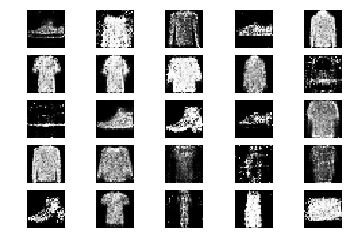

34200 [D loss: 0.623522, acc.: 65.62%] [G loss: 1.079610]
34400 [D loss: 0.586674, acc.: 71.88%] [G loss: 1.070093]
34600 [D loss: 0.613036, acc.: 67.19%] [G loss: 1.056947]
34800 [D loss: 0.594939, acc.: 68.75%] [G loss: 1.068329]
35000 [D loss: 0.659100, acc.: 57.81%] [G loss: 0.948680]


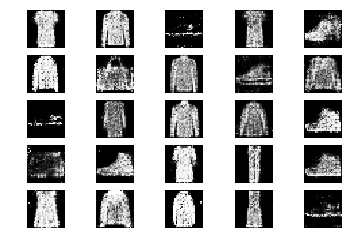

35200 [D loss: 0.598752, acc.: 67.19%] [G loss: 1.042054]
35400 [D loss: 0.615634, acc.: 71.88%] [G loss: 0.997781]
35600 [D loss: 0.588795, acc.: 67.19%] [G loss: 0.999714]
35800 [D loss: 0.643370, acc.: 62.50%] [G loss: 0.917167]
36000 [D loss: 0.490564, acc.: 79.69%] [G loss: 1.057333]


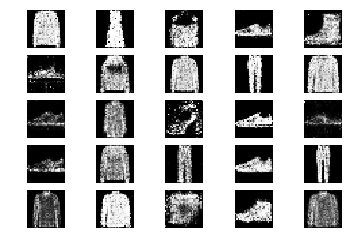

36200 [D loss: 0.584802, acc.: 68.75%] [G loss: 0.970454]
36400 [D loss: 0.540377, acc.: 78.12%] [G loss: 0.981231]
36600 [D loss: 0.690222, acc.: 53.12%] [G loss: 0.967213]
36800 [D loss: 0.616692, acc.: 68.75%] [G loss: 1.182984]
37000 [D loss: 0.636300, acc.: 64.06%] [G loss: 1.193855]


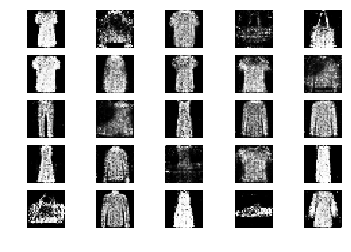

37200 [D loss: 0.555150, acc.: 67.19%] [G loss: 1.176348]
37400 [D loss: 0.535905, acc.: 76.56%] [G loss: 1.117975]
37600 [D loss: 0.579250, acc.: 71.88%] [G loss: 1.163662]
37800 [D loss: 0.556097, acc.: 73.44%] [G loss: 1.107898]
38000 [D loss: 0.625603, acc.: 65.62%] [G loss: 0.933979]


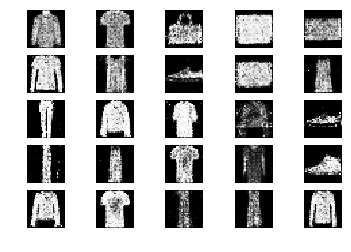

38200 [D loss: 0.622837, acc.: 71.88%] [G loss: 1.062884]
38400 [D loss: 0.569231, acc.: 73.44%] [G loss: 1.133579]
38600 [D loss: 0.647206, acc.: 60.94%] [G loss: 0.966360]
38800 [D loss: 0.557994, acc.: 64.06%] [G loss: 1.067288]
39000 [D loss: 0.646495, acc.: 62.50%] [G loss: 0.944255]


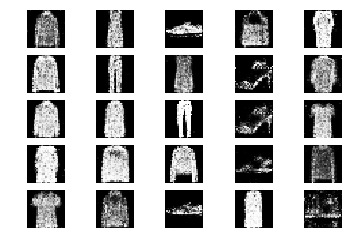

39200 [D loss: 0.545625, acc.: 71.88%] [G loss: 1.071960]
39400 [D loss: 0.562177, acc.: 68.75%] [G loss: 1.018724]
39600 [D loss: 0.620049, acc.: 64.06%] [G loss: 1.074921]
39800 [D loss: 0.625121, acc.: 70.31%] [G loss: 1.120972]
40000 [D loss: 0.637729, acc.: 59.38%] [G loss: 1.114525]


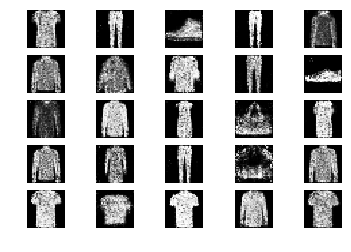

40200 [D loss: 0.619240, acc.: 67.19%] [G loss: 1.053838]
40400 [D loss: 0.681557, acc.: 65.62%] [G loss: 1.050244]
40600 [D loss: 0.627346, acc.: 65.62%] [G loss: 1.085811]
40800 [D loss: 0.638740, acc.: 57.81%] [G loss: 0.996508]
41000 [D loss: 0.566234, acc.: 70.31%] [G loss: 1.180104]


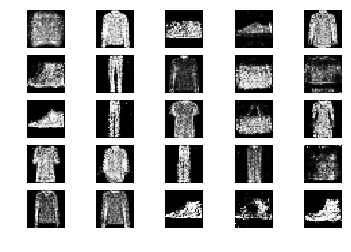

41200 [D loss: 0.656622, acc.: 60.94%] [G loss: 1.006752]
41400 [D loss: 0.551404, acc.: 73.44%] [G loss: 1.022314]
41600 [D loss: 0.594294, acc.: 65.62%] [G loss: 1.118079]
41800 [D loss: 0.558234, acc.: 71.88%] [G loss: 1.060217]
42000 [D loss: 0.614535, acc.: 60.94%] [G loss: 1.080645]


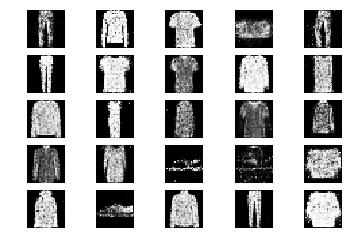

42200 [D loss: 0.576731, acc.: 71.88%] [G loss: 1.070304]
42400 [D loss: 0.655212, acc.: 67.19%] [G loss: 1.097929]
42600 [D loss: 0.541809, acc.: 65.62%] [G loss: 1.115900]
42800 [D loss: 0.650829, acc.: 62.50%] [G loss: 1.156409]
43000 [D loss: 0.592646, acc.: 65.62%] [G loss: 1.113586]


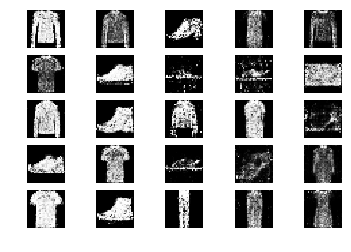

43200 [D loss: 0.643983, acc.: 62.50%] [G loss: 1.062910]
43400 [D loss: 0.585027, acc.: 67.19%] [G loss: 1.109086]
43600 [D loss: 0.596444, acc.: 64.06%] [G loss: 1.022953]
43800 [D loss: 0.639317, acc.: 64.06%] [G loss: 1.141517]
44000 [D loss: 0.564266, acc.: 78.12%] [G loss: 0.993307]


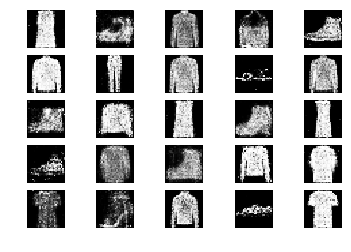

44200 [D loss: 0.603440, acc.: 67.19%] [G loss: 1.266309]
44400 [D loss: 0.566440, acc.: 73.44%] [G loss: 1.088203]
44600 [D loss: 0.565741, acc.: 65.62%] [G loss: 1.117418]
44800 [D loss: 0.653342, acc.: 53.12%] [G loss: 1.063028]
45000 [D loss: 0.670502, acc.: 59.38%] [G loss: 1.140682]


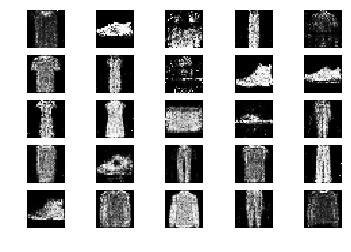

45200 [D loss: 0.688870, acc.: 57.81%] [G loss: 1.041021]
45400 [D loss: 0.691268, acc.: 53.12%] [G loss: 1.035149]
45600 [D loss: 0.593042, acc.: 64.06%] [G loss: 1.018404]
45800 [D loss: 0.581486, acc.: 68.75%] [G loss: 1.095770]
46000 [D loss: 0.547463, acc.: 73.44%] [G loss: 1.006762]


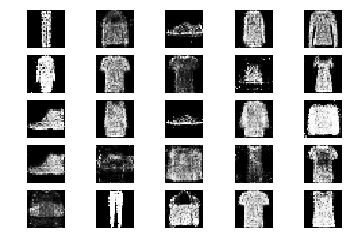

46200 [D loss: 0.685347, acc.: 65.62%] [G loss: 0.983163]
46400 [D loss: 0.580010, acc.: 62.50%] [G loss: 0.998775]
46600 [D loss: 0.654787, acc.: 65.62%] [G loss: 1.071576]
46800 [D loss: 0.580487, acc.: 70.31%] [G loss: 1.184392]
47000 [D loss: 0.534959, acc.: 73.44%] [G loss: 1.069615]


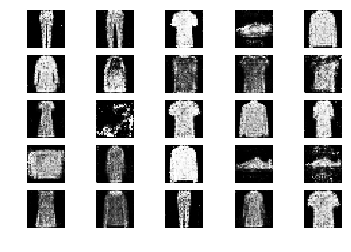

47200 [D loss: 0.631518, acc.: 60.94%] [G loss: 0.965031]
47400 [D loss: 0.617893, acc.: 60.94%] [G loss: 1.079574]
47600 [D loss: 0.604895, acc.: 59.38%] [G loss: 1.301727]
47800 [D loss: 0.640107, acc.: 65.62%] [G loss: 1.118898]
48000 [D loss: 0.620024, acc.: 62.50%] [G loss: 0.903484]


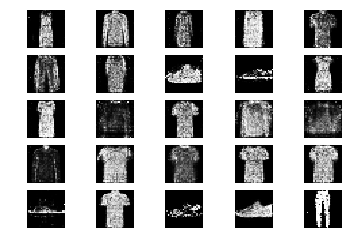

48200 [D loss: 0.543042, acc.: 75.00%] [G loss: 1.043463]
48400 [D loss: 0.561470, acc.: 67.19%] [G loss: 0.907083]
48600 [D loss: 0.639376, acc.: 64.06%] [G loss: 1.130759]
48800 [D loss: 0.686566, acc.: 59.38%] [G loss: 0.973473]
49000 [D loss: 0.612451, acc.: 62.50%] [G loss: 0.939931]


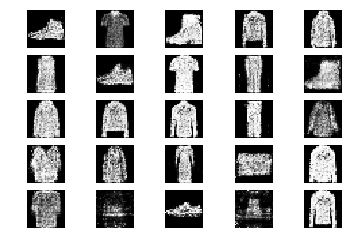

49200 [D loss: 0.548102, acc.: 73.44%] [G loss: 1.016539]
49400 [D loss: 0.602230, acc.: 75.00%] [G loss: 1.146849]
49600 [D loss: 0.632112, acc.: 59.38%] [G loss: 1.042601]
49800 [D loss: 0.631694, acc.: 65.62%] [G loss: 1.118820]


In [110]:
epochs = 50000

batch_size = 32
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
  # Train discriminator
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  if epoch % 200 == 0:
    print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

  if epoch % 1000 == 0:
    sample_images(epoch)

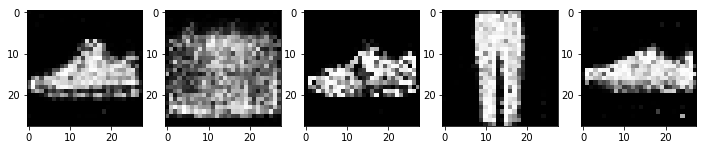

In [111]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r*c, 100))
gen_imgs = generator.predict(noise)

gen_imgs = 0.5*gen_imgs+0.5

plt.figure(figsize=(12, 6))
plt.subplot(151)
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.subplot(152)
plt.imshow(gen_imgs[1, :, :, 0], cmap='gray')
plt.subplot(153)
plt.imshow(gen_imgs[2, :, :, 0], cmap='gray')
plt.subplot(154)
plt.imshow(gen_imgs[3, :, :, 0], cmap='gray')
plt.subplot(155)
plt.imshow(gen_imgs[4, :, :, 0], cmap='gray')
plt.show()
plt.close()